In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import pydicom as dicom
from pathlib import Path
import os

print(os.getcwd())

/home/kunsu/Work/medical/medical


data link - https://www.kaggle.com/datasets/kmader/siim-medical-images

In [2]:
IMG_PATH = Path("/mnt/d/Data/medical/CT_medical_image/")
print(IMG_PATH)

/mnt/d/Data/medical/CT_medical_image


In [3]:
data_df = pd.read_csv(IMG_PATH / "overview.csv")
data_df.head()

Unnamed: 0  Age  Contrast ContrastTag  \
0           0   60      True        NONE   
1           1   69      True        NONE   
2           2   74      True     APPLIED   
3           3   75      True        NONE   
4           4   56      True        NONE   

                                      raw_input_path  id  \
0   ../data/50_50_dicom_cases\Contrast\00001 (1).dcm   0   
1  ../data/50_50_dicom_cases\Contrast\00001 (10).dcm   1   
2  ../data/50_50_dicom_cases\Contrast\00001 (11).dcm   2   
3  ../data/50_50_dicom_cases\Contrast\00001 (12).dcm   3   
4  ../data/50_50_dicom_cases\Contrast\00001 (13).dcm   4   

                            tiff_name                          dicom_name  
0  ID_0000_AGE_0060_CONTRAST_1_CT.tif  ID_0000_AGE_0060_CONTRAST_1_CT.dcm  
1  ID_0001_AGE_0069_CONTRAST_1_CT.tif  ID_0001_AGE_0069_CONTRAST_1_CT.dcm  
2  ID_0002_AGE_0074_CONTRAST_1_CT.tif  ID_0002_AGE_0074_CONTRAST_1_CT.dcm  
3  ID_0003_AGE_0075_CONTRAST_1_CT.tif  ID_0003_AGE_0075_CONTRAST_1_CT.dcm  
4  ID_0004_AGE_0056_CONTRAST_1_CT.tif  ID_0004_AGE_0056_CONTRAST_1_CT.dcm

In [4]:
data_df.keys()

Index(['Unnamed: 0', 'Age', 'Contrast', 'ContrastTag', 'raw_input_path', 'id',
       'tiff_name', 'dicom_name'],
      dtype='object')

In [5]:
def process_data(path):
    dicom_path = IMG_PATH / path
    data = pd.DataFrame([{"path": filepath} for filepath in dicom_path.glob("*.dcm")])
    data["file"] = data["path"].map(os.path.basename)
    data["ID"] = data["file"].map(lambda x: str(x.split("_")[1]))
    data["Age"] = data["file"].map(lambda x: int(x.split("_")[3]))
    data["Contrast"] = data["file"].map(lambda x: bool(int(x.split("_")[5])))
    data["Modality"] = data["file"].map(lambda x: str(x.split("_")[6].split(".")[-2]))
    return data

In [6]:
print("Number of DICOM:", len(str(IMG_PATH / "dicom_dir")))
dicom_data = process_data("dicom_dir")
dicom_data.head()

Number of DICOM: 46


path  \
0  /mnt/d/Data/medical/CT_medical_image/dicom_dir...   
1  /mnt/d/Data/medical/CT_medical_image/dicom_dir...   
2  /mnt/d/Data/medical/CT_medical_image/dicom_dir...   
3  /mnt/d/Data/medical/CT_medical_image/dicom_dir...   
4  /mnt/d/Data/medical/CT_medical_image/dicom_dir...   

                                 file    ID  Age  Contrast Modality  
0  ID_0000_AGE_0060_CONTRAST_1_CT.dcm  0000   60      True       CT  
1  ID_0001_AGE_0069_CONTRAST_1_CT.dcm  0001   69      True       CT  
2  ID_0002_AGE_0074_CONTRAST_1_CT.dcm  0002   74      True       CT  
3  ID_0003_AGE_0075_CONTRAST_1_CT.dcm  0003   75      True       CT  
4  ID_0004_AGE_0056_CONTRAST_1_CT.dcm  0004   56      True       CT

In [7]:
dicom_data.keys()

Index(['path', 'file', 'ID', 'Age', 'Contrast', 'Modality'], dtype='object')

In [8]:
def show_images(data, dim=16, imtype="dicom"):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4, 4, figsize=(16, 20))
    for i, data_row in enumerate(img_data):
        # data_row_img = dicom.read_file(data_row["path"])
        data_row_img = dicom.dcmread(data_row["path"])  # read_file() > dcmread()
        ax[i // 4, i % 4].imshow(data_row_img.pixel_array, cmap=plt.cm.bone)
        ax[i // 4, i % 4].axis("off")
        ax[i // 4, i % 4].set_title("Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast}".format(**data_row))
    plt.show()

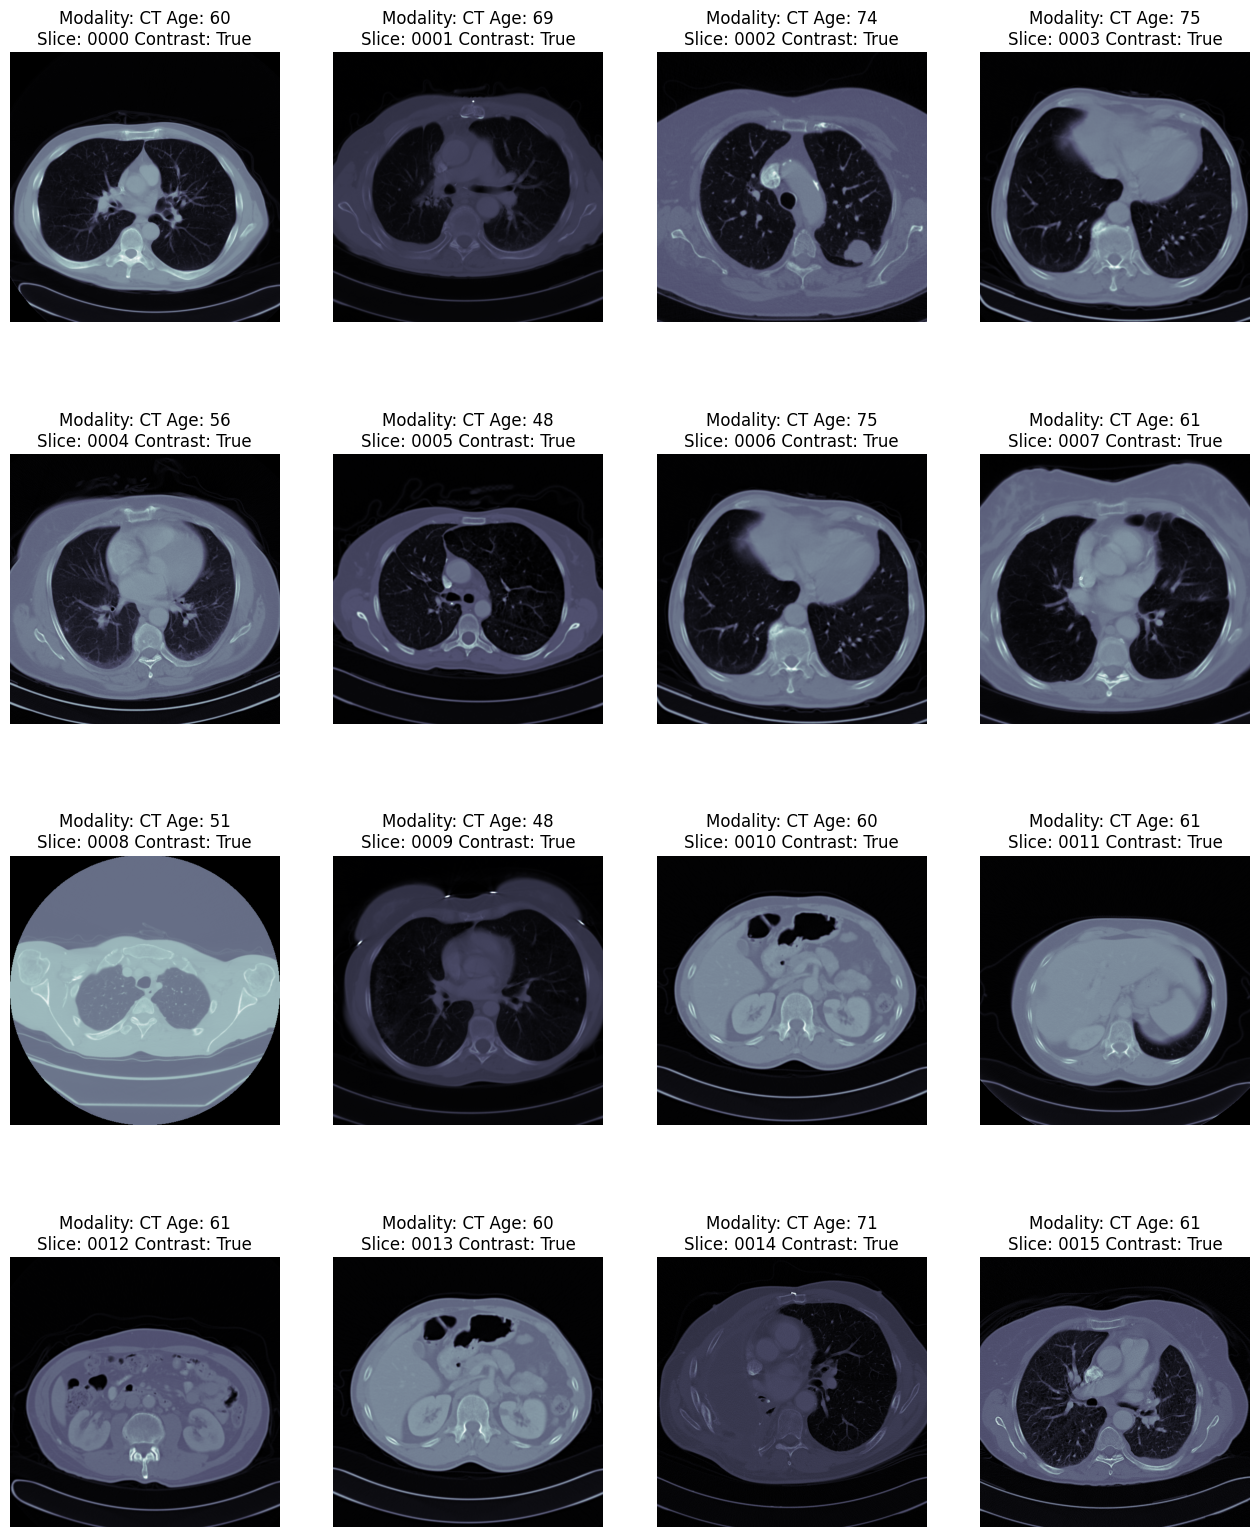

In [9]:
show_images(dicom_data, 16, "DICOM")

In [10]:
## preprocessing
# dicom_dataset = dicom.read_file(dicom_data["path"].iloc[0])
dicom_dataset = dicom.dcmread(dicom_data["path"].iloc[0])
dicom_dataset

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 194
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.108821836759549281694712274169
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4.31'
-------------------------------------------------
(0008,0000) Group Length                        UL: 430
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.7777.9002.1088218367595492

In [13]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)


def load_scan(path):
    # slices = [dicom.read_file(s) for s in path]
    slices = [dicom.dcmread(s) for s in path]
    #     slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices


import scipy


def resample(image, scan, new_spacing=[1, 1, 1]):
    # Determine current pixel spacing
    c_float = lambda x: [float(i) for i in x]
    spacing = np.array([float(1)] + c_float(scan.PixelSpacing), dtype=np.float32)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode="nearest")

    return image, new_spacing

In [14]:
scan_dataset = load_scan(dicom_data["path"].to_list())
hu_value = get_pixels_hu(scan_dataset)

In [17]:
# dicom_dataset = dicom.read_file(dicom_data["path"].iloc[0])
dicom_dataset = dicom.dcmread(dicom_data["path"].iloc[0])
print(dicom_dataset[("0028", "0030")].value)

[007.812500e-01, 007.812500e-01]


In [18]:
dicom_dataset = dicom.dcmread(dicom_data["path"].iloc[2])
print(dicom_dataset[("0028", "0030")].value)

[0.546875, 0.546875]


In [21]:
slice_n = 80
dicom_dataset = dicom.dcmread(dicom_data["path"].iloc[slice_n])
dicom_dataset[("0028", "0030")].value

[0.9765625, 0.9765625]

In [22]:
pix_resampled, spacing = resample(hu_value[[slice_n]], scan_dataset[slice_n], [1, 1, 1])
print("Shape before resampling\t", hu_value[[slice_n]].shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (1, 512, 512)
Shape after resampling	 (1, 500, 500)


/tmp/ipykernel_83497/2054659075.py:54: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode="nearest")


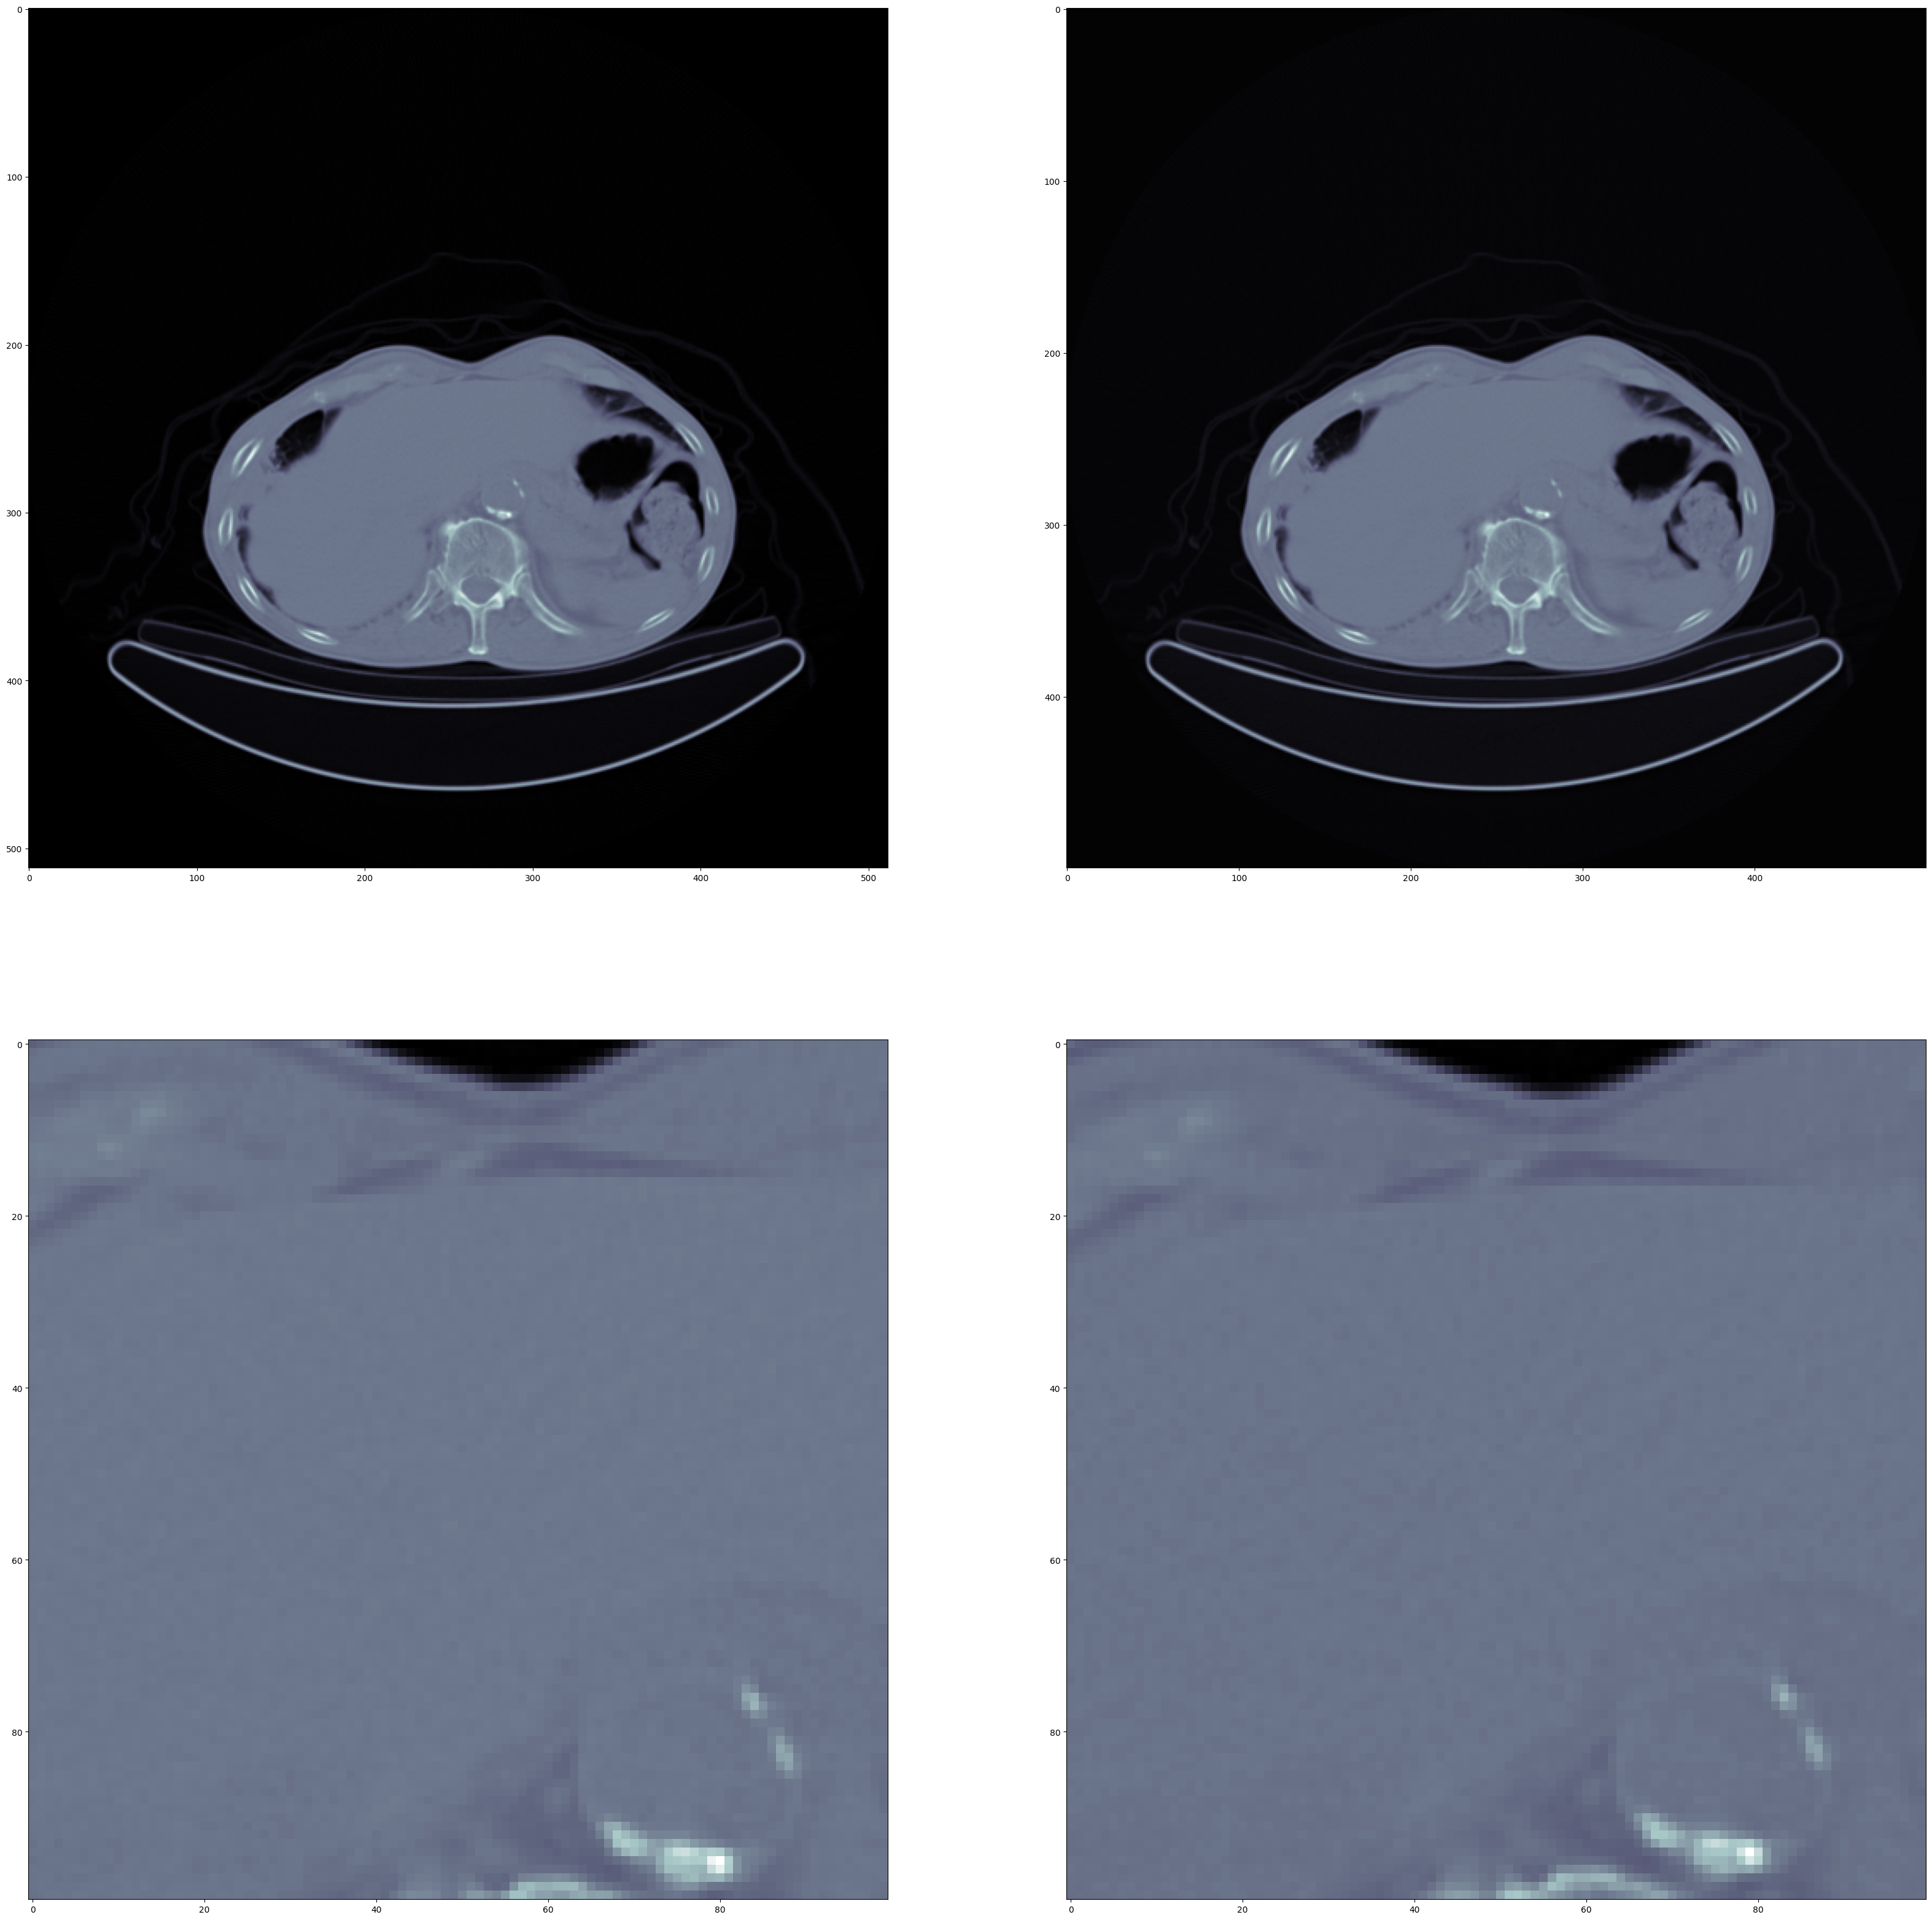

In [23]:
# print(data)
fig, axs = plt.subplots(2, 2, figsize=(40, 40))

axs[0, 0].imshow(hu_value[slice_n], cmap=plt.cm.bone)
axs[0, 0].grid(False)

axs[0, 1].imshow(pix_resampled[0], cmap=plt.cm.bone)
axs[0, 1].grid(False)

w, h = hu_value[slice_n].shape
w /= 2
h /= 2
w, h = int(w), int(h)
axs[1, 0].imshow(hu_value[slice_n][h - 50 : h + 50, w - 50 : w + 50], cmap=plt.cm.bone)
axs[1, 0].grid(False)

w, h = pix_resampled[0].shape
w /= 2
h /= 2
w, h = int(w), int(h)
axs[1, 1].imshow(pix_resampled[0, h - 50 : h + 50, w - 50 : w + 50], cmap=plt.cm.bone)
axs[1, 1].grid(False)

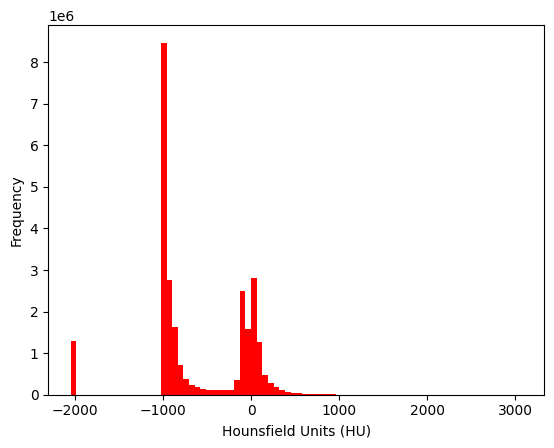

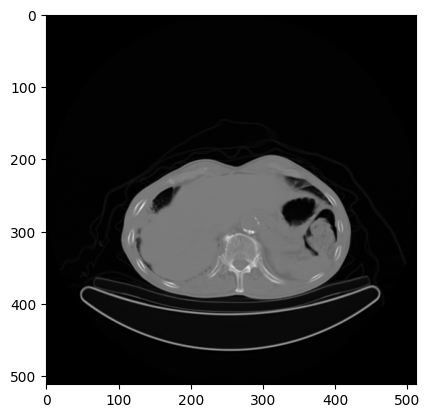

In [24]:
plt.hist(hu_value.flatten(), bins=80, color="r")
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

plt.imshow(hu_value[80], cmap=plt.cm.gray)
plt.show()
# # Show some slice in the middle
# plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
# plt.show()

In [25]:
def window_image(img, window_center, window_width, intercept, slope):

    img = img * slope + intercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max
    return img


def get_first_of_dicom_field_as_int(x):
    # get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == dicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)


def get_windowing(data):
    dicom_fields = [
        data[("0028", "1050")].value,  # window center
        data[("0028", "1051")].value,  # window width
        data[("0028", "1052")].value,  # intercept
        data[("0028", "1053")].value,
    ]  # slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

In [26]:
get_windowing(dicom_dataset)

[40, 450, -1024, 1]

In [27]:
w_center, w_width, intercept, slope = get_windowing(dicom_dataset)

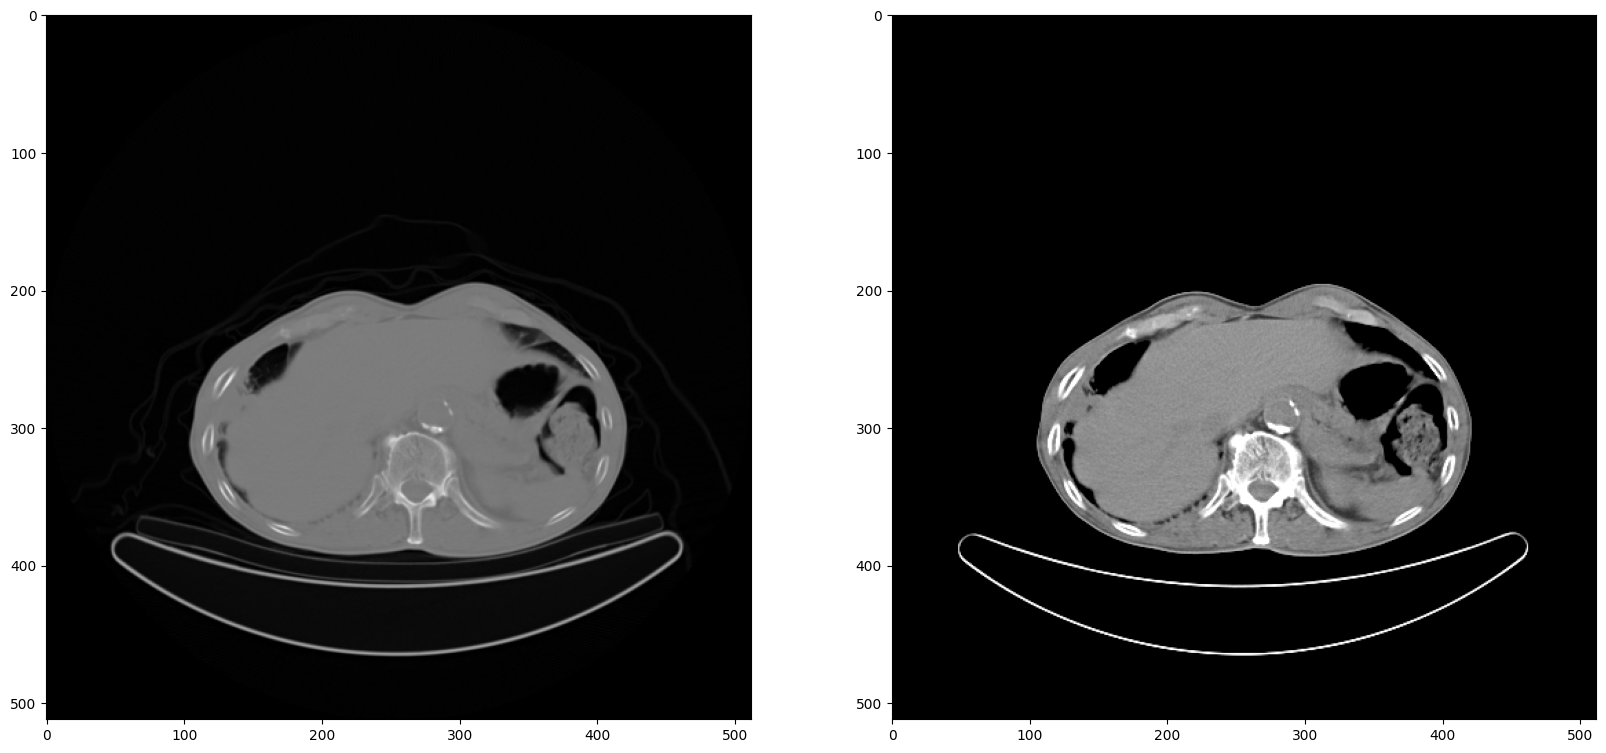

In [28]:
import pydicom
import matplotlib.pyplot as plt

dicom_dataset = scan_dataset[80]
# print(data)
fig, axs = plt.subplots(1, 2, figsize=(20, 40))
window_center, window_width, intercept, slope = get_windowing(dicom_dataset)

# displaying the image
img = dicom_dataset.pixel_array
axs[0].imshow(img, cmap="gray")
axs[0].grid(False)
img = window_image(img, window_center, window_width, intercept, slope)
axs[1].imshow(img, cmap="gray")
axs[1].grid(False)

In [33]:
def show_images(data, dim=16, imtype="TIFF"):
    img_data = list(data[:dim].T.to_dict().values())
    f, ax = plt.subplots(4, 4, figsize=(16, 20))
    for i, data_row in enumerate(img_data):
        # data_row_img = dicom.read_file(data_row["path"])
        data_row_img = dicom.dcmread(data_row["path"])
        window_center, window_width, intercept, slope = get_windowing(data_row_img)
        img = data_row_img.pixel_array
        img = window_image(img, window_center, window_width, intercept, slope)

        ax[i // 4, i % 4].imshow(img, cmap=plt.cm.bone)
        ax[i // 4, i % 4].axis("off")
        ax[i // 4, i % 4].set_title("Modality: {Modality} Age: {Age}\nSlice: {ID} Contrast: {Contrast}".format(**data_row))
    plt.show()

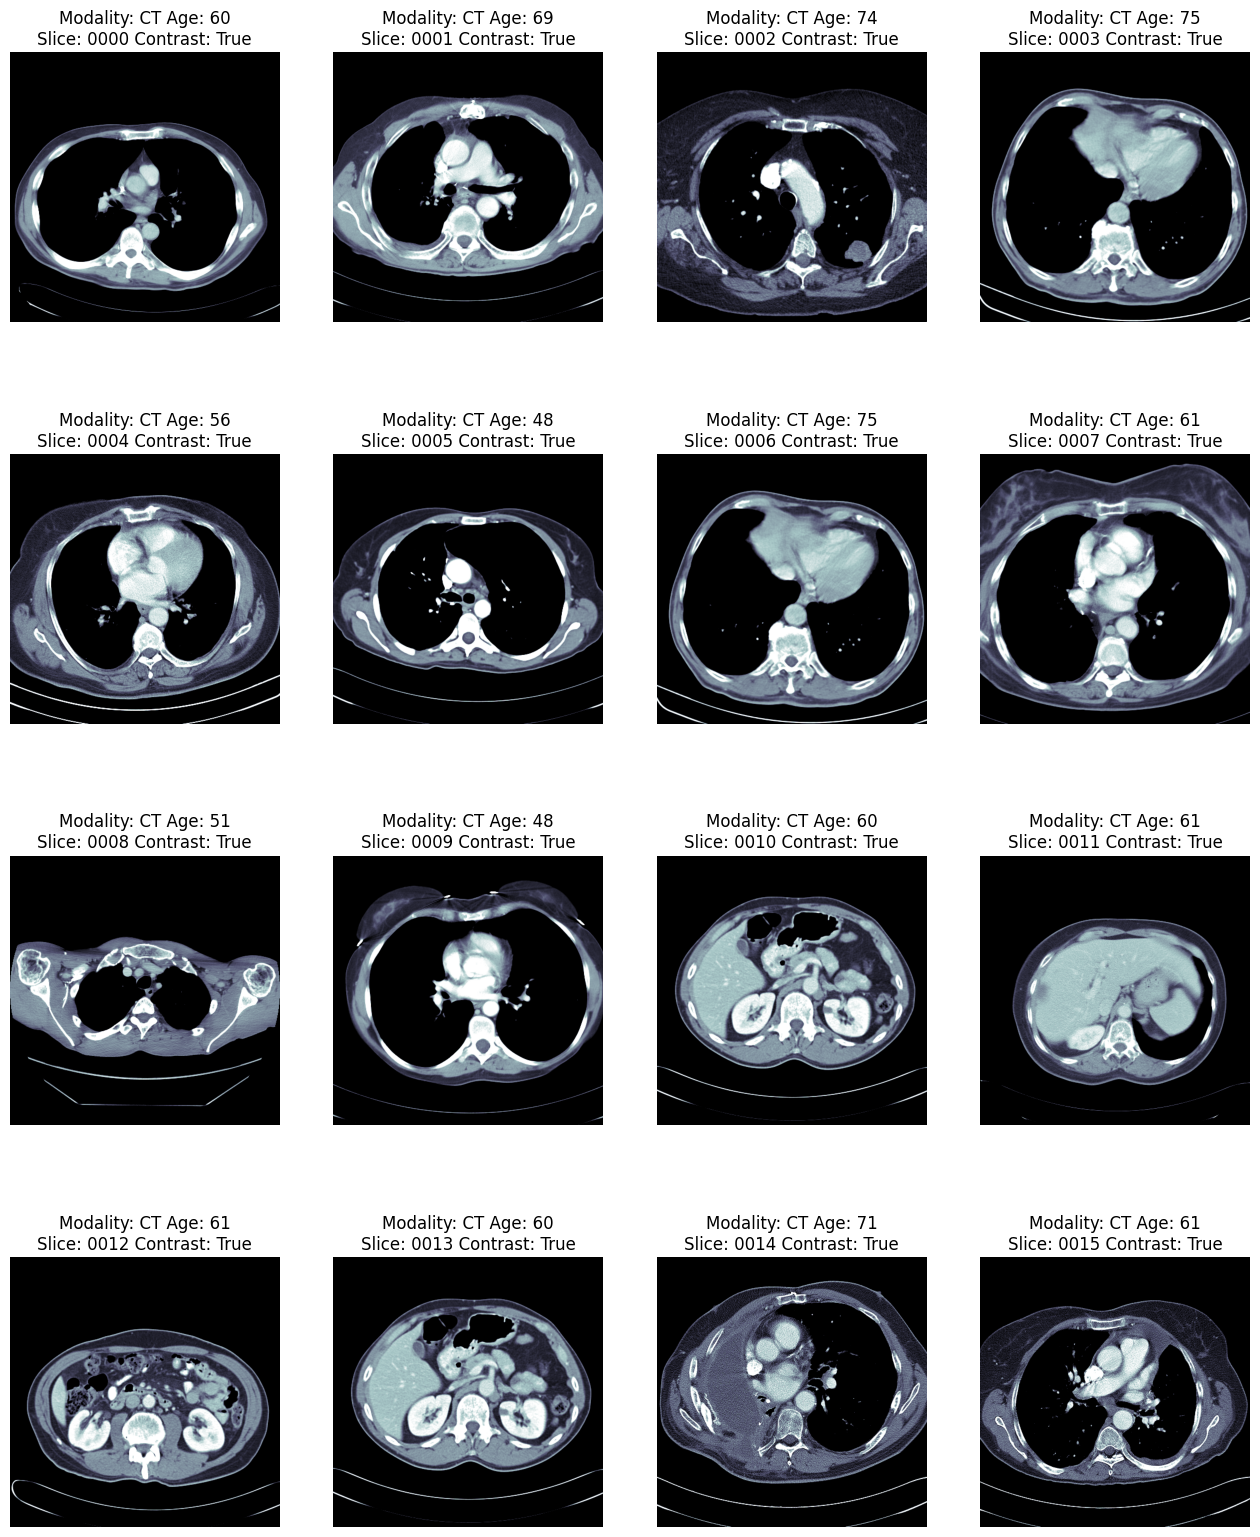

In [34]:
show_images(dicom_data, 16, "DICOM")

In [35]:
window_center, window_width, intercept, slope

(-1000, 200, -1024, 1)

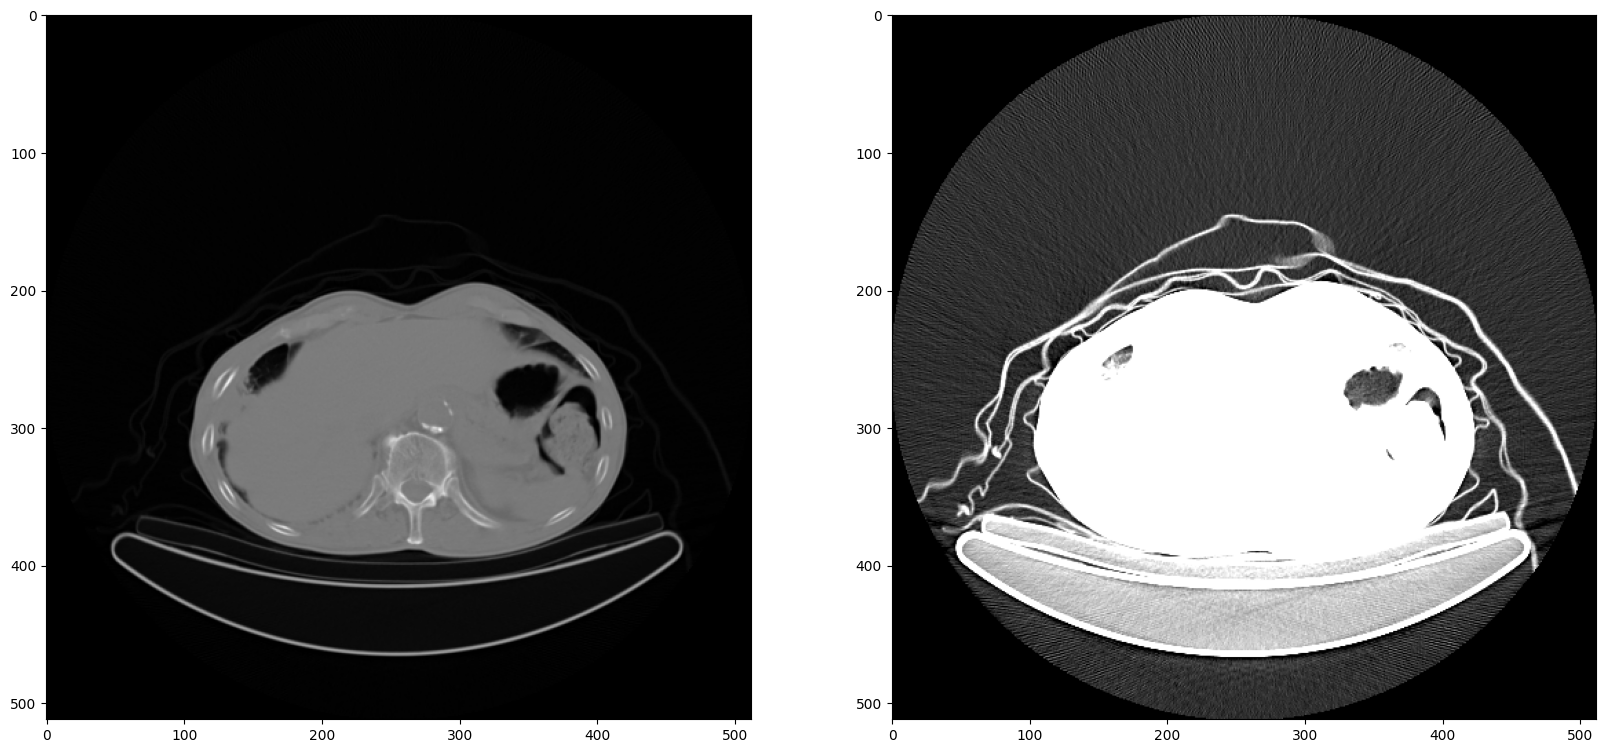

In [36]:
import pydicom
import matplotlib.pyplot as plt

dicom_dataset = scan_dataset[80]
# print(data)
fig, axs = plt.subplots(1, 2, figsize=(20, 40))
# window_center , window_width, intercept, slope = get_windowing(dicom_dataset)
window_center, window_width, intercept, slope = -1000, 200, -1024, 1

# displaying the image
img = dicom_dataset.pixel_array
axs[0].imshow(img, cmap="gray")
axs[0].grid(False)
img = window_image(img, window_center, window_width, intercept, slope)
axs[1].imshow(img, cmap="gray")
axs[1].grid(False)